<a href="https://colab.research.google.com/github/SudeepSarkar/sarkar-computer-vision-lectures/blob/main/CV_Module_5_2__Neural_Networks_Basics_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Neural Network Basics 2
## (Dive into Deep Learning https://d2l.ai/chapter_multilayer-perceptrons/index.html)

* The material for this notebook is mainly from the Open Source book -- Dive into Deep Learning. I have adapted a few things for the Computer Vision course at the University of South Florida, Tampa.

* Some figures are from Richard Szeliski's vision textbook for this course.

# Topics covered

* You will learn how to implement a single-layer, softmax-based classification network **using PyTorch** and train it.

* You will learn about multilayer perceptrons, their power over a single layer, and how to implement them in PyTorch. You will also learn about the popular ReLU activation function.

**Concepts learned:** hidden layers, multilayer perceptron, ReLU, Tanh, PyTorch constructs for deep learning




## Code: setup

In [ ]:
import matplotlib.pyplot as plt
import torch
import torchvision
from torch import nn
from torch.nn import functional as F
!pip install d2l==0.16.2 # package for the book - Dive into Deep Learning

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 77 kB 1.3 MB/s 
     |████████████████████████████████| 121 kB 61.4 MB/s 
     |████████████████████████████████| 1.6 MB 20.8 MB/s 
     |████████████████████████████████| 83 kB 865 kB/s 


# Model Single Layer - Softmax

* Let  $\mathbf{X}$ be $n \times d$ matrix representing a minibatch of examples with feature dimensionality (number of inputs) $d$ and batch size $n$.

* Weights are captured in a $\mathbf{W}$ is a ${d \times q}$ matrix
and the bias is a ${1\times q}$ vector $\mathbf{b}$.

* The fully connected layer with softmax can compute outputs for **all** inputs in a minibatch **simultaneously** using matrix multiply. No for-loops needed.

\begin{eqnarray}
\mathbf{O} & = &\mathbf{X} \mathbf{W} + \mathbf{b} \\ 
\hat{\mathbf{Y}} & = &\mathrm{softmax}(\mathbf{O}) \\
\end{eqnarray}


* This loss function is commonly called the **cross-entropy loss**.


\begin{equation} 
l(\mathbf{y}, \hat{\mathbf{y}}) = - \sum_{j=1}^q y_j \log \hat{y}_j
\end{equation}


## Code: Initializing Model Parameters: `linear_net`

* To implement our softmax-linear model, we just need to add one fully-connected layer with 10 outputs. 
    * https://pytorch.org/docs/stable/generated/torch.nn.Sequential.html -- the input is passed on from one to the next in a sequential fashion
    * https://pytorch.org/docs/stable/generated/torch.flatten.html?highlight=flatten#torch.flatten -- returns the same object most of the time, not a copy.
    * https://pytorch.org/docs/stable/generated/torch.nn.Linear.html?highlight=nn%20linear#torch.nn.Linear

* We initialize the weights at random
with zero mean and standard deviation 0.01.
    * https://pytorch.org/docs/stable/generated/torch.nn.Module.html?highlight=apply#torch.nn.Module.apply


In [ ]:
# PyTorch does not implicitly reshape the inputs. Thus we define the flatten
# layer to reshape the inputs before the linear layer in our network
linear_net = nn.Sequential(
                    nn.Flatten(), 
                    nn.Linear(784, 10)
                    )

def init_weights(m):
    if type(m) == nn.Linear:
        nn.init.normal_(m.weight, std=0.01)

linear_net.apply(init_weights);
print(linear_net)

total_params = sum(p.numel() for p in linear_net.parameters() if p.requires_grad)

print('\n Total parameters:', total_params)

Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=784, out_features=10, bias=True)
)

 Total parameters: 7850


## Code: Cross entropy loss: `loss`


* Cross-entropy loss

\begin{equation} 
l(\mathbf{y}, \hat{\mathbf{y}}) = - \sum_{j=1}^q y_j \log \hat{y}_j
\end{equation}

* We can combine Softmax and Cross-entropy Loss in one single operation, saving on some computation complexity.

* Even though softmax involves exponential computing functions, we ultimately intend to take their log when calculating the cross-entropy loss.


* We can combine softmax and cross-entropy

$$
\begin{aligned}
\log{(\hat y_j)} & = \log\left( \frac{\exp(o_j)}{\sum_k \exp(o_k)}\right) \\
& = \log{(\exp(o_j))}-\log{\left( \sum_k \exp(o_k) \right)} \\
& = o_j  -\log{\left( \sum_k \exp(o_k) \right)}.
\end{aligned}
$$

* Instead of passing softmax probabilities into our new loss function, we will **pass the logits ($o_j$) and compute the softmax and its log all at once inside the cross-entropy loss function,**

\begin{equation} 
l(\mathbf{y}, \hat{\mathbf{y}}) = - \sum_{j=1}^q y_j o_j +  \log{\left( \sum_k \exp(o_k) \right) \sum_{j=1}^q y_j}
\end{equation}


* We will want to keep the conventional softmax function handy if we ever want to evaluate the output probabilities by our model.

* https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html?highlight=crossentropyloss#torch.nn.CrossEntropyLoss

In [ ]:
loss = nn.CrossEntropyLoss()

## Code: Optimization Algorithm: `trainer`

* Here, we **use minibatch stochastic gradient descent** with a learning rate of 0.1 as the optimization algorithm. Note that this is the same as we applied in the linear regression example, illustrating the optimizers' general applicability.


In [ ]:
trainer = torch.optim.SGD(linear_net.parameters(), lr=0.1)

##Code: `Animator` class

In [ ]:
from IPython import display

class Animator: 
    """For plotting data in animation."""
    def __init__(self, xlabel=None, ylabel=None, legend=None, xlim=None,
                 ylim=None, xscale='linear', yscale='linear',
                 fmts=('-', 'm--', 'g-.', 'r:'), nrows=1, ncols=1,
                 figsize=(5, 5)):
        # Incrementally plot multiple lines
        if legend is None:
            legend = []
        d2l.use_svg_display()
        self.fig, self.axes = d2l.plt.subplots(nrows, ncols, figsize=figsize)
        if nrows * ncols == 1:
            self.axes = [self.axes,]
        # Use a lambda function to capture arguments
        self.config_axes = lambda: d2l.set_axes(self.axes[
            0], xlabel, ylabel, xlim, ylim, xscale, yscale, legend)
        self.X, self.Y, self.fmts = None, None, fmts

    def add(self, x, y):
        # Add multiple data points into the figure
        if not hasattr(y, "__len__"):
            y = [y]
        n = len(y)
        if not hasattr(x, "__len__"):
            x = [x] * n  #repeat x axis values n times, one for each plot
        if not self.X:
            self.X = [[] for _ in range(n)]
        if not self.Y:
            self.Y = [[] for _ in range(n)]
        for i, (a, b) in enumerate(zip(x, y)):
            if a is not None and b is not None:
                self.X[i].append(a)
                self.Y[i].append(b)
        self.axes[0].cla()
        for x, y, fmt in zip(self.X, self.Y, self.fmts):
            self.axes[0].plot(x, y, fmt)
        self.config_axes()
        display.display(self.fig)
        display.clear_output(wait=True)

## Code: `evaluate_accuracy`

In [ ]:
def accuracy(y_hat, y):
    """Compute the number of correct predictions."""
    if len(y_hat.shape) > 1 and y_hat.shape[1] > 1: #The output is a vector -- not just a scalar
        y_hat = y_hat.argmax(axis=1)
    cmp = y_hat.type(y.dtype) == y
    return float(cmp.type(y.dtype).sum())

In [ ]:
class Accumulator:
    """For accumulating sums over `n` variables."""
    def __init__(self, n):
        self.data = [0.0] * n # creates [0.0, 0.0, ....n-times]

    def add(self, *args):
        self.data = [a + float(b) for a, b in zip(self.data, args)]
        # Example: let self.data = [10, 15] and args be [3, 4]
        # zip(self.data, args) will produce the paired iterable [(10, 3), (15, 4)]
        # the for loop with go over these paired entries adding them up to result in [13, 19]

    def reset(self):
        self.data = [0.0] * len(self.data) # creates [0.0, 0.0, ....n-times]

    def __getitem__(self, idx):
        return self.data[idx]

In [ ]:
def evaluate_accuracy(net, data_iter):  
    """Compute the accuracy for a model on a dataset."""
    if isinstance(net, torch.nn.Module):
        net.eval()  # Set the model to evaluation mode
    metric = Accumulator(2)  # No. of correct predictions, no. of predictions

    with torch.no_grad():
        for X, y in data_iter: # iterate over the minibatches
        #--------------------------------------------------
            metric.add(accuracy(net(X), y), y.numel())
        #--------------------------------------------------
    return metric[0] / metric[1]

## Code: Load train and test data

  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting ../data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ../data/FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting ../data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ../data/FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting ../data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ../data/FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting ../data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/FashionMNIST/raw



/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:566: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


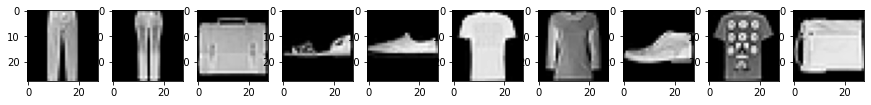

In [ ]:
import torch
import numpy as np

from IPython import display
from d2l import torch as d2l

batch_size = 256
#--------------------------------------------------
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size)
#--------------------------------------------------

# display random images from 10 minibatches
fig, axs = plt.subplots(nrows=1, ncols=10) 
fig.set_size_inches (15, 5)
for i in range(10) :
    X, y = next(iter(train_iter))
    axs[i].imshow(X[np.random.randint(0, batch_size),0].reshape(28,28), 'gray');

## Code: Training



In [ ]:
#-------------------------------------------------------------------------------
def train_one_epoch (net, train_iter, loss, updater): 
    """The training loop defined in Chapter 3."""
    # Set the model to training mode
    net.train()
    # Sum of training loss, sum of training accuracy, no. of examples
    metric = Accumulator(3)
    for X, y in train_iter:
        # Compute gradients and update parameters
        y_hat = net(X)
        l = loss(y_hat, y)
        
        # Using PyTorch in-built optimizer & loss criterion
        updater.zero_grad()
        l.backward()
        updater.step()
        metric.add(float(l) * len(y), accuracy(y_hat, y), y.numel())
    # Return training loss and training accuracy
    return metric[0] / metric[2], metric[1] / metric[2]

#-------------------------------------------------------------------------------
def train_full (net, train_iter, test_iter, loss, num_epochs, updater): 

    animator = Animator(xlabel='epoch', xlim=[1, num_epochs], ylim=[0.3, 0.9],
                        legend=['train loss', 'train acc', 'test acc'])
    
    for epoch in range(num_epochs):
        train_metrics = train_one_epoch (net, train_iter, loss, updater)
        test_acc = evaluate_accuracy(net, test_iter)

        animator.add(epoch + 1, train_metrics + (test_acc,))
        
    train_loss, train_acc = train_metrics
    return (train_loss, train_acc, test_acc)

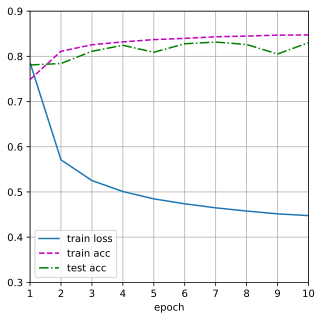

In [ ]:
num_epochs = 10

train_full (linear_net, train_iter, test_iter, loss, num_epochs, trainer);

As before, this algorithm converges to a solution
that achieves a decent accuracy,
albeit this time with fewer lines of code than before.


## Summary

* For cross-entropy loss, softmax regression can be combined with cross-entropy loss to save some computational time.

* Note that in many cases, a deep learning framework takes  precautions beyond these most well-known tricks to ensure numerical stability, saving us from even more pitfalls that we would encounter if we tried to code all of our models from scratch in practice.

# Assignment

1. Vary the hyperparameters as follows and document the loss, accuracy on train set, accurarcy on test set.

    batch sizes (batch_size): 256, 128, 64 

    number of epochs (num_epochs): 10, 20, 30

    learning rate (lr): 0.1, 0.01, 0.2

2. Comment on the learning behavior observed.


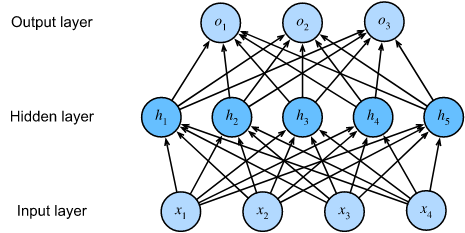

# Multilayer Perceptrons



## Hidden Layers -- just stacking is not enough

* If our labels indeed were related to our input data by an affine transformation, then our earlier linear-softmax approach would be sufficient. However, an affine transformation is a *strong* assumption.

* We can overcome these limitations of linear models and handle a more general class of functions by incorporating one or more **hidden layers**.

* The easiest way to do this is to stack **many fully-connected layers** on top of each other. Each layer feeds into the layer above it until we generate outputs.

* We can think of the first $L-1$ layers as our representation and the final layer as our linear predictor. This architecture is commonly called a **multilayer perceptron**, often abbreviated as *MLP*.

* In the example above, the MLP has 4 inputs, 3 outputs, and its hidden layer contains 5 hidden units. 

* Since the input layer does not involve any calculations, producing outputs with this network requires implementing the computations for both the hidden and output layers; thus, the number of layers in this MLP is 2.

*  Note that these layers are both fully connected. Every input influences every neuron in the hidden layer, and each of these, in turn, influences
every neuron in the output layer. 

* However, the parameterization cost of MLPs with fully connected layers
can be prohibitively high, which may motivate a tradeoff between parameter saving and model effectiveness even without changing the input or output size.

* Note that our model now requires us to track and update additional parameters after adding the hidden layer. So what have we gained in exchange? You might be surprised to discover that---in the model defined above---*we gain nothing for our troubles*!

* **Two affine transforms following each other result in another affine transform! (Can you mathematically show this?) So the many layers can be adequately modeled using one layer!**

    * The operations of the two layers can be represented by

    \begin{equation}
    \begin{aligned}
        \mathbf{H} & = \mathbf{X} \mathbf{W}^{(1)} + \mathbf{b}^{(1)}, \\
        \mathbf{O} & = \mathbf{H}\mathbf{W}^{(2)} + \mathbf{b}^{(2)}.
    \end{aligned}
    \end{equation}

    * We can view the equivalence formally by proving that for any values of the weights, we can collapse out the hidden layer, yielding an equivalent single-layer model with parameters $\mathbf{W} = \mathbf{W}^{(1)}\mathbf{W}^{(2)}$ and $\mathbf{b} = \mathbf{b}^{(1)} \mathbf{W}^{(2)} + \mathbf{b}^{(2)}$:

    \begin{eqnarray}
    \mathbf{O} & = & (\mathbf{X} \mathbf{W}^{(1)} + \mathbf{b}^{(1)})\mathbf{W}^{(2)} + \mathbf{b}^{(2)} \\
    & = & \mathbf{X} \mathbf{W}^{(1)}\mathbf{W}^{(2)} + \mathbf{b}^{(1)} \mathbf{W}^{(2)} + \mathbf{b}^{(2)} \\
    & = & \mathbf{X} \mathbf{W} + \mathbf{b}.
    \end{eqnarray}



## From Linear to Nonlinear

* We need one more key ingredient: **a nonlinear activation function** $\sigma$ to be applied to each hidden unit following the affine transformation.

* The outputs of activation functions (e.g., $\sigma(\cdot)$) are called *activations*. In general, with activation functions in place, it is no longer possible to collapse our MLP into a linear model:

\begin{eqnarray}
\mathbf{H} & = & \sigma(\mathbf{X} \mathbf{W}^{(1)} + \mathbf{b}^{(1)}),\\
\mathbf{O} & = & \mathbf{H}\mathbf{W}^{(2)} + \mathbf{b}^{(2)}.
\end{eqnarray}

* To build more general MLPs, we can continue stacking such hidden layers, e.g., $\mathbf{H}^{(1)} = \sigma_1(\mathbf{X} \mathbf{W}^{(1)} + \mathbf{b}^{(1)})$
and $\mathbf{H}^{(2)} = \sigma_2(\mathbf{H}^{(1)} \mathbf{W}^{(2)} + \mathbf{b}^{(2)})$, one atop another, yielding ever more expressive models.


* Universal Approximators

    * Moreover, for certain choices of the activation function, it is widely known that MLPs are universal approximators.

    * Even with a single-hidden-layer network, given enough nodes (possibly absurdly many), and the right set of weights, we can model any function, though learning that function is the hard part.

    * Moreover, just because a single-hidden-layer network *can* learn any function does not mean that you should try to solve all of your problems with single-hidden-layer networks.

    * In fact, we can approximate many functions much more compactly by using deeper (vs. wider) networks. We will touch upon more rigorous arguments in subsequent chapters.





## Activation Functions

Activation functions decide whether a neuron should be activated by calculating the weighted sum and adding bias. They are differentiable operators to transform input signals into outputs, while most add non-linearity. Because activation functions are fundamental to deep learning, **let us briefly survey some common activation functions**.

### ReLU Function

* The most popular choice, due to both simplicity of implementation and its good performance on various predictive tasks, is the *rectified linear unit* (*ReLU*). **ReLU provides a straightforward nonlinear transformation**.

* Given an element $x$, the function is defined
as the maximum of that element and $0$:

$$\operatorname{ReLU}(x) = \max(x, 0).$$

* Informally, the ReLU function retains only positive elements and discards all harmful elements by setting the corresponding activations to 0. To gain some intuition, we can plot the function. As you can see, the activation function is piecewise linear.


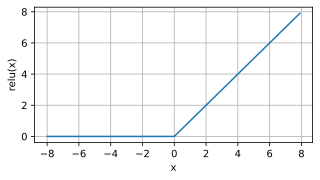

In [ ]:
x = torch.arange(-8.0, 8.0, 0.1, requires_grad=True)
y = torch.relu(x)
d2l.plot(x.detach(), y.detach(), 'x', 'relu(x)', figsize=(5, 2.5))

* **Derivative** of RELU: Mathematically, the function does not have a derivative at x=0, but in practice, we ignore it and assign a zero derivative value for x=0.

* Note that the derivative is either zero or positive. **Operationally, when we chain derivatives together during an update, this layer will stop derivatives from passing through if the value is negative.** The derivative will not propagate down if the node's value is negative.


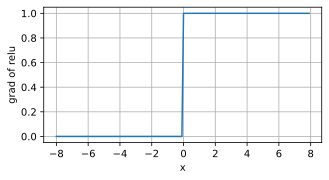

In [ ]:
y.backward(torch.ones_like(x), retain_graph=True)
d2l.plot(x.detach(), x.grad, 'x', 'grad of relu', figsize=(5, 2.5))


### Sigmoid Function

* **The *sigmoid function* transforms its inputs to outputs that lie on the interval (0, 1).**

* For that reason, the sigmoid is often called a *squashing function*: it squashes any input in the range (-inf, inf) to some value in the range (0, 1):

\begin{equation}
\operatorname{sigmoid}(x) = \frac{1}{1 + \exp(-x)}
\end{equation}

* In the earliest neural networks, scientists were interested in modeling biological neurons that either *fire* or *do not fire*. Thus the pioneers of this field, going back to McCulloch and Pitts, the inventors of the artificial neuron, focused on thresholding units.
    * A thresholding activation takes value 0 when its input is below some threshold and 1 when the input exceeds the threshold.

* When attention shifted to gradient-based learning, the sigmoid function was a natural choice because it is a smooth, differentiable approximation to a thresholding unit.

* Sigmoids are still widely used as activation functions on the output units when we interpret the outputs as probabilities for binary classification problems (you can think of the sigmoid as a particular case of the softmax, just for one node).

* However, the sigmoid has mostly been replaced by the simpler and more easily trainable ReLU for most use in hidden layers.

* Below, we plot the sigmoid function. Note that when the input is close to 0,
the sigmoid function approaches a linear transformation.


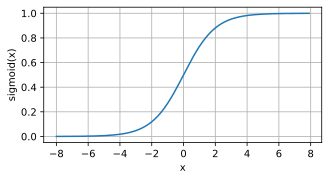

In [ ]:
y = torch.sigmoid(x)
d2l.plot(x.detach(), y.detach(), 'x', 'sigmoid(x)', figsize=(5, 2.5))

* The **derivative** of the sigmoid function is given by the following equation:

$$\frac{d}{dx} \operatorname{sigmoid}(x) = \frac{\exp(-x)}{(1 + \exp(-x))^2} = \operatorname{sigmoid}(x)\left(1-\operatorname{sigmoid}(x)\right).$$


* The derivative of the sigmoid function is plotted below. Note that when the input is 0, the derivative of the sigmoid function reaches a maximum of 0.25.
As the input diverges from 0 in either direction, the derivative approaches 0.


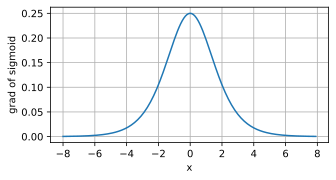

In [ ]:
# Clear out previous gradients
x.grad.data.zero_()
y.backward(torch.ones_like(x), retain_graph=True)
d2l.plot(x.detach(), x.grad, 'x', 'grad of sigmoid', figsize=(5, 2.5))

### Tanh Function

* Like the sigmoid function, **the tanh (hyperbolic tangent) function also squashes its inputs**, transforming them into elements on the interval (**between -1 and 1**):

\begin{equation}
\operatorname{tanh}(x) = \frac{1 - \exp(-2x)}{1 + \exp(-2x)}
\end{equation}

* We plot the tanh function below. Note that as the input nears 0, the tanh function approaches a linear transformation. Although the shape of the function is similar to that of the sigmoid function, the tanh function exhibits point symmetry about the origin of the coordinate system.


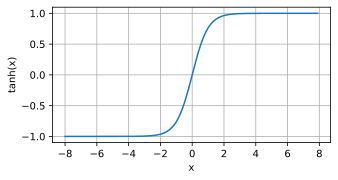

In [ ]:
y = torch.tanh(x)
d2l.plot(x.detach(), y.detach(), 'x', 'tanh(x)', figsize=(5, 2.5))

* The **derivative** of the tanh function is:

\begin{equation}
\frac{d}{dx} \operatorname{tanh}(x) = 1 - \operatorname{tanh}^2(x)
\end{equation}

* The derivative of tanh function is plotted below. As the input nears 0, the derivative of the tanh function approaches a maximum of 1. And as we saw with the sigmoid function, as the input moves away from 0 in either direction, the derivative of the tanh function approaches 0.


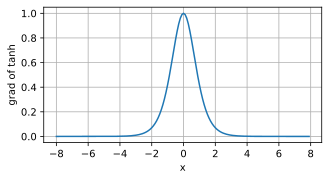

In [ ]:
# Clear out previous gradients.
x.grad.data.zero_()
y.backward(torch.ones_like(x), retain_graph=True)
d2l.plot(x.detach(), x.grad, 'x', 'grad of tanh', figsize=(5, 2.5))

## Summary

* MLP adds one or multiple fully-connected hidden layers between the output and input layers and transforms the output of the hidden layer via an activation function.

* Commonly-used activation functions include the ReLU function, the sigmoid function, and the tanh function.


## Code: Model

* We add *two* fully-connected layers (previously, we added *one*). The first is [**our hidden layer**], which (**contains 256 hidden units and applies the ReLU activation function**). The second is our output layer.


In [ ]:
mlp_net = nn.Sequential(
                    nn.Flatten(), 
                    nn.Linear(784, 256), 
                    nn.ReLU(),
                    nn.Linear(256, 10)
                    )

def init_weights(m):
    if type(m) == nn.Linear:
        nn.init.normal_(m.weight, std=0.01)

mlp_net.apply(init_weights);
print(mlp_net)


total_params = sum(p.numel() for p in mlp_net.parameters() if p.requires_grad)
print('\n Total parameters:', total_params)

Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=784, out_features=256, bias=True)
  (2): ReLU()
  (3): Linear(in_features=256, out_features=10, bias=True)
)

 Total parameters: 203530


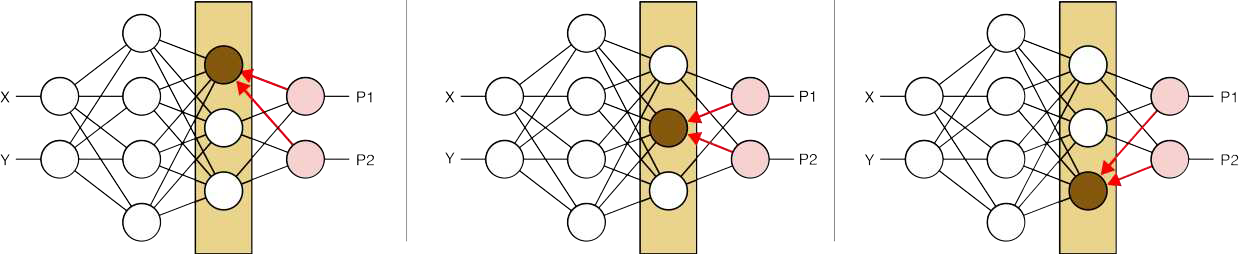

**Backpropagating** the derivatives (errors) through an intermediate layer of the deep network (© Glassner (2018). The derivatives of the loss function applied to a single training example with respect to each of the pink unit inputs are summed together and the process is repeated chaining backward through the network.

## Code: Training
**The training loop** is exactly the same as when we implemented softmax regression. This modularity enables us to separate matters concerning the model architecture from operations on it.


In [ ]:
batch_size, lr, num_epochs = 256, 0.03, 30
loss = nn.CrossEntropyLoss()
trainer = torch.optim.SGD(mlp_net.parameters(), lr=lr) # network used here...

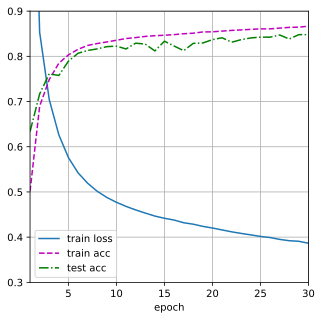

In [ ]:
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size)
train_full (mlp_net, train_iter, test_iter, loss, num_epochs, trainer)

## Prediction

Now that training is complete, our model is ready **to classify some images.**
Given a series of images, we will compare their actual labels (first line of text output) and the predictions from the model (second line of text output).


## Code: `predict`

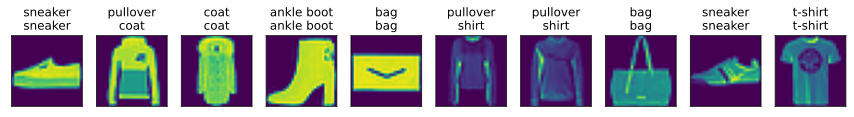

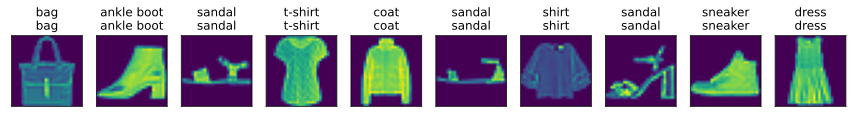

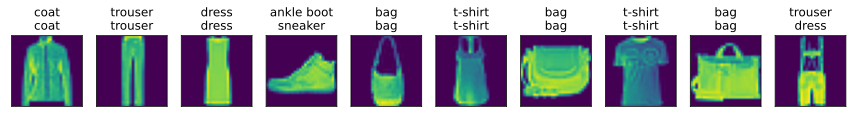

In [ ]:
def predict (net, test_iter, n=10):

    X, y = next(iter(train_iter))

    #for X, y in test_iter:
    #    break
    trues = d2l.get_fashion_mnist_labels(y)
    preds = d2l.get_fashion_mnist_labels(net(X).argmax(axis=1)) ## This is how you invoke the model
    titles = [true + '\n' + pred for true, pred in zip(trues, preds)]
    d2l.show_images(X[0:n].reshape((n, 28, 28)), 1, n, titles=titles[0:n])

predict (mlp_net, test_iter)
predict (mlp_net, test_iter)
predict (mlp_net, test_iter)